In [1]:
# imports needed for URL scraping
import requests
from bs4 import BeautifulSoup

# imports the custom complexity class
from gunningfog import GunningFog

# imports needed for returns data manipulation and plotting
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
def gunning_fog_lst(comp_urls):
    '''
    This function serves as the main body of the Gunning
    Fog functionality. When provided with a list of URLs,
    the function iterates through each URL and produces
    the relevant excerpt of the earnings call and inputs
    this string to a GunningFog object, appending each
    complexity score to a list. The final return value
    is a list of ordered complexity scores by URL.
    
    Args: list of string URLs
    Returns: list of complexity scores
    '''
    # empty list of complexities to be filled in
    complexities = []
    
    # iterates through each URL
    for url in comp_urls:
        # gets the website info through a request and parses
        # the HTML, getting the text and splitting by
        # new line
        req = requests.get(url)
        soup = BeautifulSoup(req.content, "html.parser")
        text = soup.get_text().split("\n")
        
        # makes a list of the company participants in the earnings call
        execs = []
        for i in range(len(text)):
            if text[i] == "Company Participants":
                pos = i + 1
                # once the section is found, iterate through each item
                # and get the name by splitting by -
                while text[pos] != "Conference Call Participants":
                    execs.append(text[pos].split("-")[0][:-1])
                    pos += 1
                break
        
        # start after the line mentioning the first executive's name
        # this begins the relevant dialogue
        start = text.index(execs[0]) + 1
        exec_lst = []
        # iterate until the Q and A section of the call
        for i in range(start, len(text)):
            phrase = text[i].strip()
            if phrase == "Question-and-Answer Session":
                break
            # do not include the executive names
            elif phrase in execs:
                continue
            # append the relevant dialogue to a list
            else:
                exec_lst.append(phrase)
        
        # make string by concatenating lines of dialogue
        exec_str = ""
        for phrase in exec_lst:
            exec_str += phrase + " "
        
        # pass string to GunningFog object
        fog = GunningFog(exec_str)
        
        # append the URL's complexity to the initial list
        complexities.append(fog.gFogIndex())
        
    return complexities

In [3]:
# list of 13 company tickers used
companies = ["AIG", "AIMC", "ALL", "ALLT", "BCO", "CADE", "CLAR", "DE", "DXPE", "HHC", "HURN", "INFU", "INSM"]

# list of the 13 company URLs
comp_urls = ["https://seekingalpha.com/article/4261066-american-international-group-inc-aig-ceo-brian-duperreault-on-q1-2019-results-earnings-call",
             "https://seekingalpha.com/article/4257313-altra-industrial-motion-corp-aimc-ceo-carl-christenson-on-q1-2019-results-earnings-call",
             "https://seekingalpha.com/article/4259328-allstate-corporation-all-ceo-tom-wilson-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4263877-allot-ltd-allt-ceo-on-erez-antebi-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4256277-brinks-company-bco-ceo-doug-pertz-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4257794-cadence-bancorporation-cade-ceo-paul-murphy-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4260743-clarus-corporation-clar-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4241565-deere-and-company-de-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4263033-dxp-enterprises-inc-dxpe-ceo-david-little-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4261129-howard-hughes-corporations-hhc-ceo-david-weinreb-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4258852-huron-consulting-group-inc-hurn-ceo-james-roth-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4263856-infusystem-holdings-inc-infu-ceo-rich-dilorio-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4260973-insmed-inc-insm-ceo-william-lewis-on-q1-2019-results-earnings-call-transcript"
            ]

# use the declared function to get list of complexities
complexity_list = gunning_fog_lst(comp_urls)

print(complexity_list)

[15.436101225702547, 13.360783990051559, 14.085951219512197, 13.616715716313989, 14.459105668058095, 13.62897531771649, 15.602926057840225, 13.524035740501683, 11.710533018009825, 13.5795195954488, 13.613526804687027, 12.268684025334272, 14.20848192547592]


In [4]:
# make dataframe with pre-processed ticker data
df = pd.read_csv("data.csv")
# make new dataframe with only 13 companies
newDf = df[companies].copy()

# empty returns list
L = []
# 
for i in range(len(newDf.columns)):
    # calculate percent change in 2019 Q1 returns
    L.append(100 * (newDf.iloc[12, i] - newDf.iloc[0, i]) / newDf.iloc[0, i])

# dataframe with just tickers and their return percentages
df_returns = pd.DataFrame(L, index = companies)

# make into list for plotting
returns_list = list(df_returns[0])

print(returns_list)

[8.859197833637097, 20.236342189896856, 15.204743497891563, 31.229771552557928, 15.43822628741082, 6.834791265235797, 25.269341122244068, 5.027244301956937, 34.45790472915617, 8.1909290829718, -3.8477146309859727, 40.92218519214515, 36.765395047134916]


Figure(432x432)


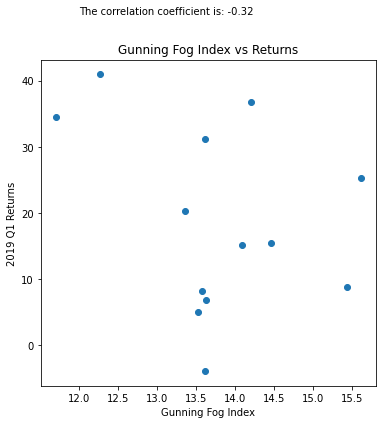

In [5]:
# calculate the correlation coefficient
my_number = np.corrcoef(complexity_list, returns_list)[0, 1]

# create a subplot
fig, ax = plt.subplots(figsize = (6, 6))

# add a scatter graph to the axis
ax.scatter(complexity_list, returns_list)

# set title
ax.title.set_text('Gunning Fog Index vs Returns')

# set axis labels
ax.set(xlabel = 'Gunning Fog Index', ylabel = '2019 Q1 Returns')

# add the correlation coefficient to the axis
ax.text(12, 50, "The correlation coefficient is: " + str(np.round(my_number, 2)))

print(fig)

Figure(432x432)


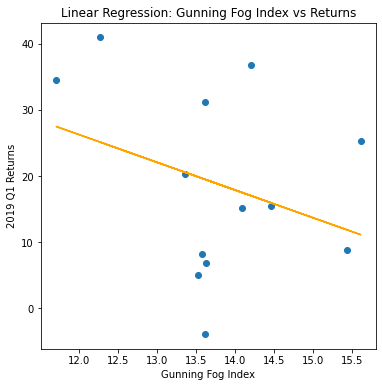

In [6]:
# create a subplot
fig2, ax2 = plt.subplots(figsize = (6, 6))

# turns the complexity_list into a numpy array
x = np.array(complexity_list)

# create basic scatterplot
ax2.scatter(complexity_list, returns_list)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(complexity_list, returns_list, 1)

# add linear regression line to scatterplot
ax2.plot(x, m*x+b, "orange")

# sets a title
ax2.title.set_text("Linear Regression: Gunning Fog Index vs Returns")

# sets axis labels
ax2.set(xlabel = "Gunning Fog Index", ylabel = "2019 Q1 Returns")

print(fig2)